# Цель лабораторной работы
Изучение линейных моделей, SVM и деревьев решений.
# Задание 
1. Выберите набор данных (датасет) для решения задачи классификации или регрессии.
2. В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
3. С использованием метода train_test_split разделите выборку на обучающую и тестовую.
4. Обучите следующие модели:
    - одну из линейных моделей;
    - SVM;
    - дерево решений.
5. Оцените качество моделей с помощью двух подходящих для задачи метрик. Сравните качество полученных моделей.

# Ход выполнения работы

## 1) Набор данных для решения задачи классификации или регрессии


### В качестве набора данных используется набор по исследованию качества белых вин 

Датасет состоит из одного файла:
- wine.csv

Файл содержит следующие колонки:
1. fixed acidity         — фиксированная кислотность 
2. volatile acidity      — летучая кислотность 
3. citric acid           — лимонная кислота 
4. residual sugar        — остаточный сахар
5. chlorides             — хлориды
6. free sulfur dioxide   — свободный диоксид серы 
7. total sulfur dioxide  — общая двуокись серы 
8. density               — плотность 
9. pH                    — потенциал водорода 
10. sulphates            — сульфаты 
11. alcohol              — алкоголь 
12. quality              — качество алкоголя (выходной параметр) 

### Импортируем библиотеки

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from gmdhpy import gmdn
%matplotlib inline 
sns.set(style="ticks")

ModuleNotFoundError: No module named 'gmdhpy'

#### Отрисовываю  ROC-кривую

In [2]:
def draw_roc_curve(y_true, y_score, pos_label=1, average='micro'):
    fpr, tpr, thresholds = roc_curve(y_true, y_score, 
                                     pos_label=pos_label)
    roc_auc_value = roc_auc_score(y_true, y_score, average=average)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_value)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

#### 2) Разделение выборки на обучающую и тестовую

In [3]:
def split(filehandler, delimiter=';', row_limit=3500,
          output_name_template='wine%s.csv', output_path='.', keep_headers=True):
    import csv
    reader = csv.reader(filehandler, delimiter=delimiter)
    current_piece = 1
    current_out_path = os.path.join(
        output_path,
        output_name_template % current_piece
    )
    current_out_writer = csv.writer(open(current_out_path, 'w'), delimiter=delimiter)
    current_limit = row_limit
    if keep_headers:
        headers = next(reader)
        current_out_writer.writerow(headers)
    for i, row in enumerate(reader):
        if i + 1 > current_limit:
            current_piece += 1
            current_limit = row_limit * current_piece
            current_out_path = os.path.join(
                output_path,
                output_name_template % current_piece
            )
            current_out_writer = csv.writer(open(current_out_path, 'w'), delimiter=delimiter)
            if keep_headers:
                current_out_writer.writerow(headers)
        current_out_writer.writerow(row)

In [5]:
split(open('wine.csv', 'r'));

In [8]:
os.rename('wine1.csv', 'wine_Train.csv')
os.rename('wine2.csv', 'wine_Test.csv')

In [9]:
# Обучающая выборка:
train = pd.read_csv('wine_Train.csv', sep=";")
# Тестовая выборка:
test = pd.read_csv('wine_Test.csv', sep=";")

 ### Проверим правильность создания обучающей и тестовой выборок

In [10]:
train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [11]:
test.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,6.0,0.28,0.27,15.5,0.036,31.0,134.0,0.99408,3.19,0.44,13.0,7
1,6.7,0.24,0.36,8.4,0.042,42.0,123.0,0.99473,3.34,0.52,10.9,6
2,6.7,0.29,0.45,14.3,0.054,30.0,181.0,0.99869,3.14,0.57,9.1,5
3,6.9,0.33,0.31,4.2,0.040,21.0,93.0,0.98960,3.18,0.48,13.4,7
4,6.5,0.16,0.34,1.4,0.029,29.0,133.0,0.99108,3.33,0.64,11.5,7


### 3) Проведение разведочного анализа данных

In [12]:
train.shape, test.shape

((3500, 12), (1398, 12))

### Проверим, одинаковы ли типы данных в столбцах обучающего и тестового датасета

In [13]:
train.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

In [14]:
test.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

**Проверяем датасеты на наличие пустых значений:**

In [15]:
train.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [16]:
test.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

### Уникальные значения целевого признака

In [17]:
train['quality'].unique()

array([6, 5, 7, 8, 4, 3, 9], dtype=int64)

### Рассмотри распределение цеелвых значений в обучающей и тестовой выборках

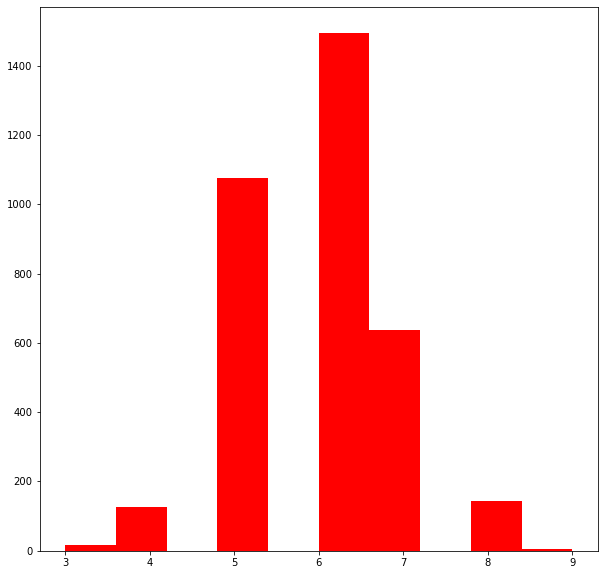

In [18]:
fig, ax = plt.subplots(figsize=(10,10)) 
plt.hist(train['quality'], color="r")
plt.show()

**Оценим здесь же плотность вероятности распределения:**

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='quality', ylabel='Density'>

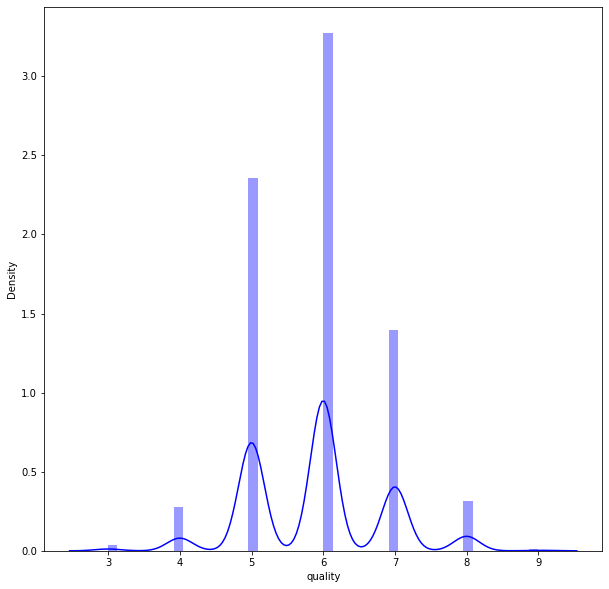

In [20]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.distplot(train['quality'], color="b")

### Подсчитаем дисбаланс классов для обучающей выборки

In [21]:
#посчитаем дисбаланс классов
total = train.shape[0]
class_6, class_5, class_7, class_8, class_4, class_3, class_9 = train['quality'].value_counts()
print('Класс 3 составляет {}%, \nкласс 4 составляет {}%, \nкласс 5 составляет {}%, \nкласс 6 составляет {}%, \nкласс 7 составляет {}%, \nкласс 8 составляет {}%, \nкласс 9 составляет {}%.'
      .format(round(class_3 / total, 4)*100, 
              round(class_4 / total, 4)*100,
              round(class_5 / total, 4)*100,
              round(class_6 / total, 4)*100,
              round(class_7 / total, 4)*100,
              round(class_8 / total, 4)*100,
              round(class_9 / total, 4)*100))

Класс 3 составляет 0.51%, 
класс 4 составляет 3.5999999999999996%, 
класс 5 составляет 30.769999999999996%, 
класс 6 составляет 42.69%, 
класс 7 составляет 18.17%, 
класс 8 составляет 4.109999999999999%, 
класс 9 составляет 0.13999999999999999%.


In [22]:
train['quality'].value_counts()

6    1494
5    1077
7     636
8     144
4     126
3      18
9       5
Name: quality, dtype: int64

### Подсчитаем дисбаланс классов для тестовой выборки

In [23]:
#посчитаем дисбаланс классов для тестовой выборки 
total = test.shape[0]
class_6, class_5, class_7, class_8, class_4, class_3, class_9 = train['quality'].value_counts()
print('Класс 3 составляет {}%, \nкласс 4 составляет {}%, \nкласс 5 составляет {}%, \nкласс 6 составляет {}%, \nкласс 7 составляет {}%, \nкласс 8 составляет {}%, \nкласс 9 составляет {}%.'
      .format(round(class_3 / total, 4)*100, 
              round(class_4 / total, 4)*100,
              round(class_5 / total, 4)*100,
              round(class_6 / total, 4)*100,
              round(class_7 / total, 4)*100,
              round(class_8 / total, 4)*100,
              round(class_9 / total, 4)*100))

Класс 3 составляет 1.29%, 
класс 4 составляет 9.01%, 
класс 5 составляет 77.03999999999999%, 
класс 6 составляет 106.87%, 
класс 7 составляет 45.49%, 
класс 8 составляет 10.299999999999999%, 
класс 9 составляет 0.36%.


### Распределенеи классов в тестовой выборке

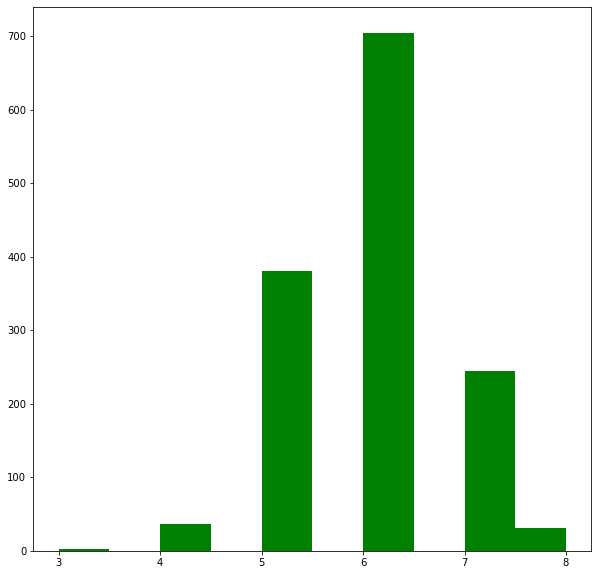

In [24]:
fig, ax = plt.subplots(figsize=(10,10)) 
plt.hist(test['quality'], color="g")
plt.show()

### Оценим плотность вероятности распределения

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='quality', ylabel='Density'>

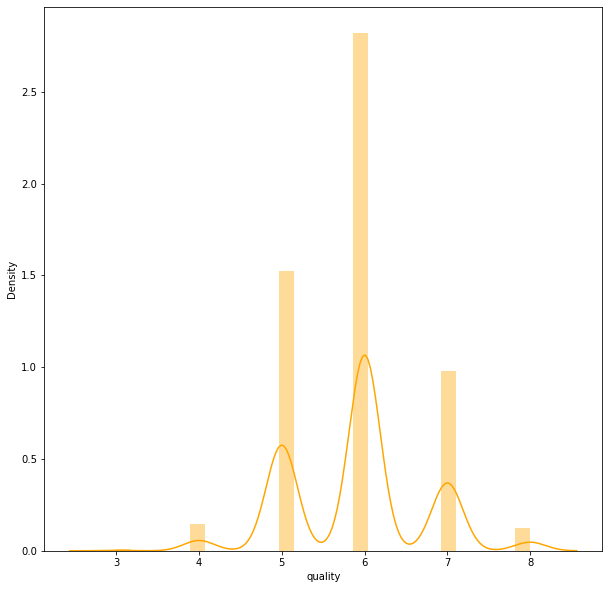

In [25]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.distplot(test['quality'], color="orange")

### Выводы об оценке дисбаланса классов
Дисбаланс классов неравномерен к рамках обучающей и тестовой выборках по отдельности. 

Также сложилась такая ситуация, что количество уникальных значений целевого признака в тестовой выборке меньше. Это следствие дисбаланса распределения классов. 

Было выявлено, что что для задачи классификации подходят не все классы (нам не подходят классы, которые встречаются < 10% раз).

Поэтому для задачи классификации у нас будет только 2 класса:
- оценка качества 6;
- оценка качества 7.

In [26]:
train.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

Кодирование признаков не требуется, поскольку все данные представлены в числовом виде.
Для построения моделей будем использовать все признаки.
Объединим обучающую и тестовую выборки для масштабирования данных. Для начала создадим вспомогательные колонки для возможности дальнейшего разделения целого датасета

In [27]:
train['dataset'] = 'TRAIN'
test['dataset'] = 'TEST'

### Выберем столбцы для объединения датасетов

In [28]:
#Колонки для объединения
join_cols = ['dataset', 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality']

In [29]:
data_all = pd.concat([train[join_cols], test[join_cols]])

### Проверяем корректность объединения

In [30]:
assert data_all.shape[0] == train.shape[0]+test.shape[0]

In [31]:
data_all.head()

,dataset,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,TRAIN,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,TRAIN,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,TRAIN,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,TRAIN,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,TRAIN,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


### Выберем столбцы для масштабирования

In [32]:
# Числовые колонки для масштабирования
scale_cols = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol']

In [33]:
sc1 = MinMaxScaler()
sc1_data = sc1.fit_transform(data_all[scale_cols])

### Добавляем масштабированные данные в наш датасет

In [34]:
for i in range(len(scale_cols)):
    col = scale_cols[i]
    new_col_name = col + '_scaled'
    data_all[new_col_name] = sc1_data[:,i]

### Проверяем корректность

In [35]:
data_all.head()

,dataset,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,...,volatile acidity_scaled,citric acid_scaled,residual sugar_scaled,chlorides_scaled,free sulfur dioxide_scaled,total sulfur dioxide_scaled,density_scaled,pH_scaled,sulphates_scaled,alcohol_scaled
0,TRAIN,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,...,0.186275,0.216867,0.308282,0.106825,0.149826,0.373550,0.267785,0.254545,0.267442,0.129032
1,TRAIN,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,...,0.215686,0.204819,0.015337,0.118694,0.041812,0.285383,0.132832,0.527273,0.313953,0.241935
2,TRAIN,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,...,0.196078,0.240964,0.096626,0.121662,0.097561,0.204176,0.154039,0.490909,0.255814,0.338710
3,TRAIN,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,...,0.147059,0.192771,0.121166,0.145401,0.156794,0.410673,0.163678,0.427273,0.209302,0.306452
4,TRAIN,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,...,0.147059,0.192771,0.121166,0.145401,0.156794,0.410673,0.163678,0.427273,0.209302,0.306452


### Посмотрим, повлияло ли масштабирование на распределение данных

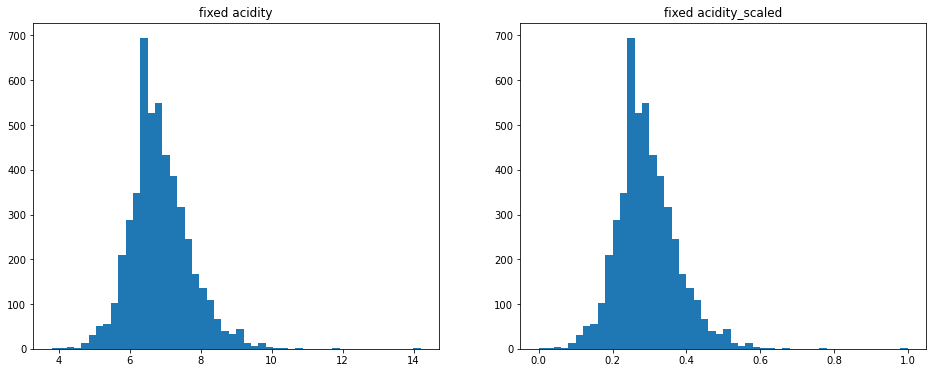

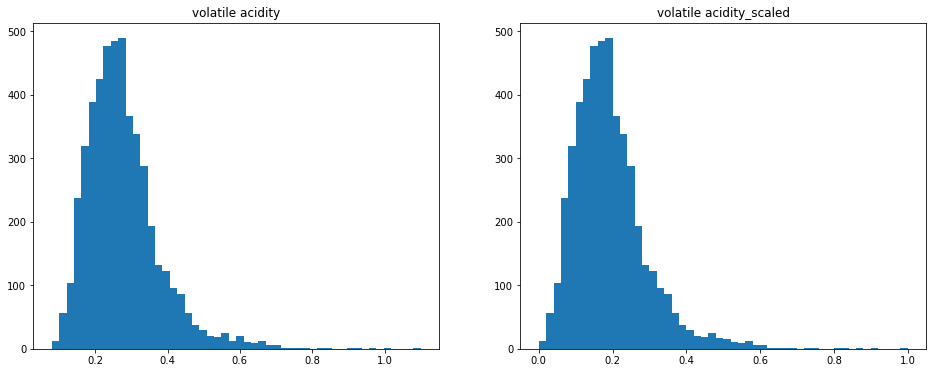

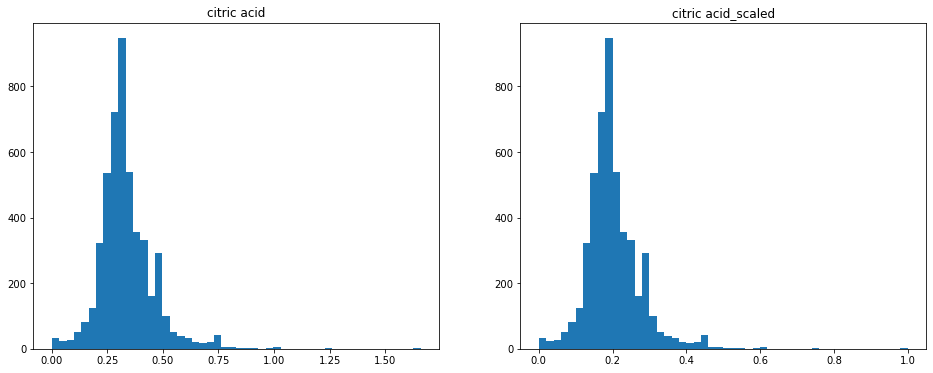

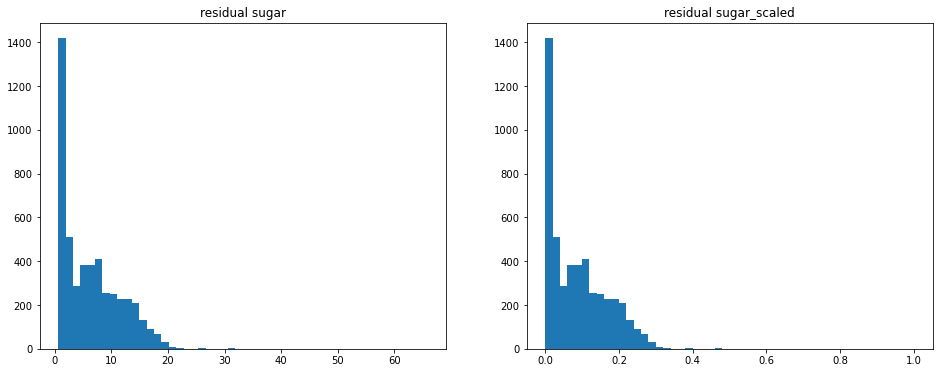

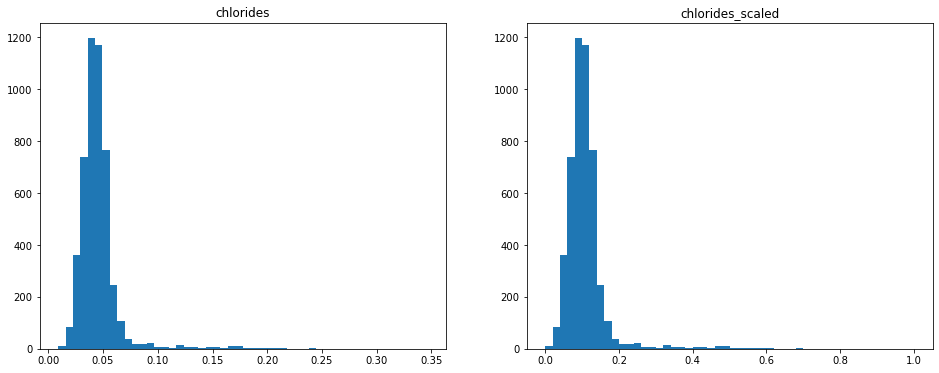

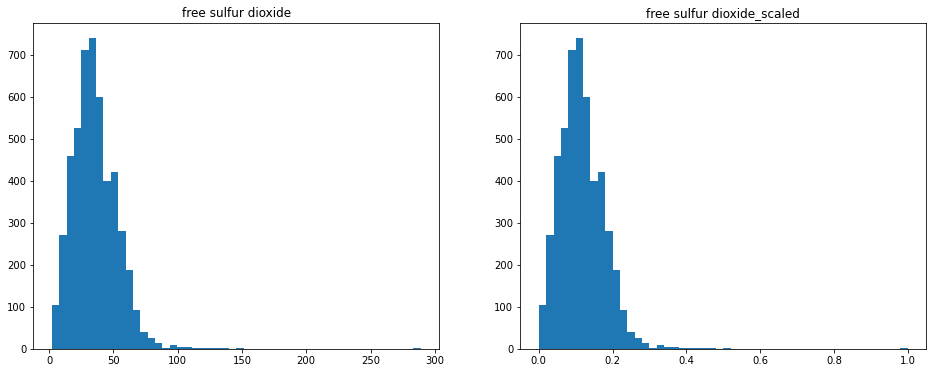

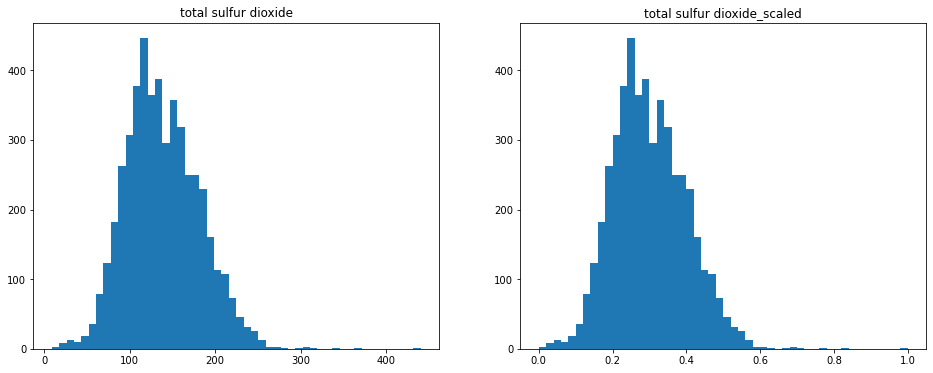

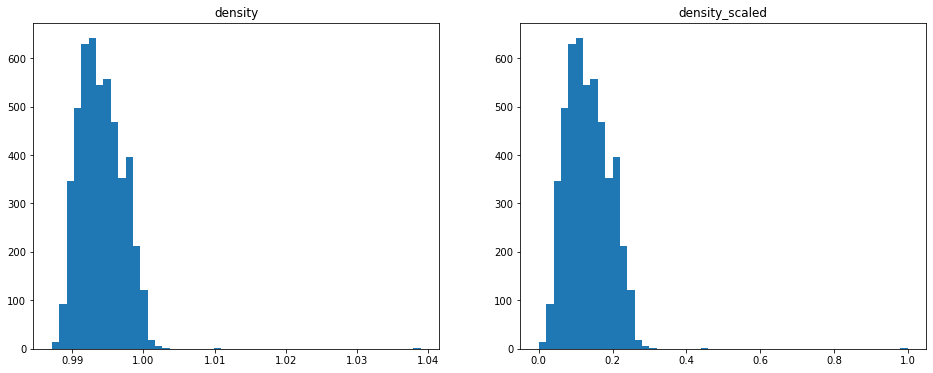

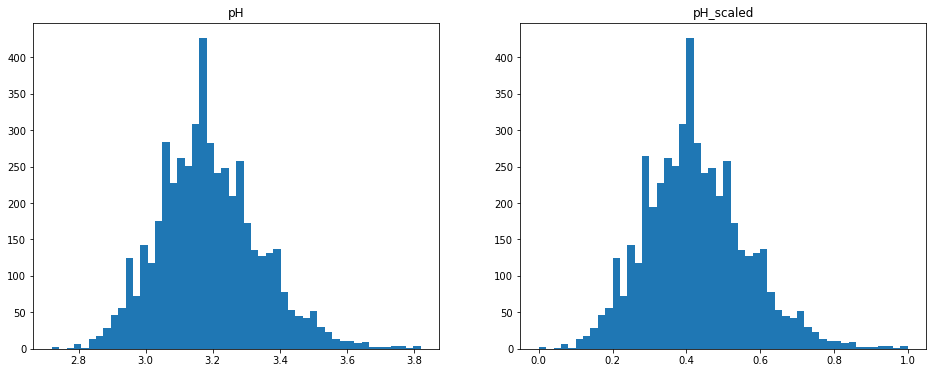

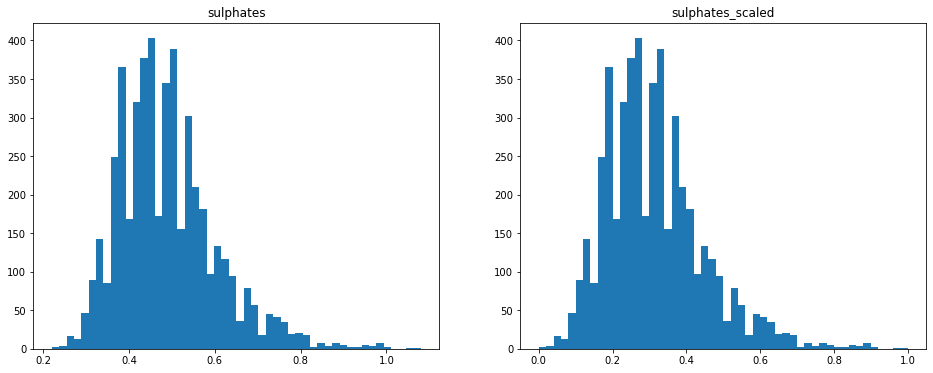

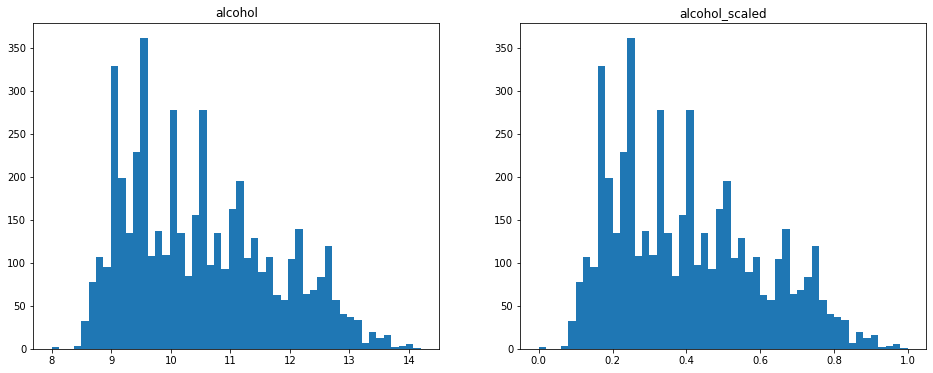

In [36]:
for col in scale_cols:
    col_scaled = col + '_scaled'
    fig, ax = plt.subplots(1, 2, figsize=(16,6))
    ax[0].hist(data_all[col], 50)
    ax[1].hist(data_all[col_scaled], 50)
    ax[0].title.set_text(col)
    ax[1].title.set_text(col_scaled)
    plt.show()

Mасштабирование данных не повлияло на их распределение

### Включим тестовую выборку в корреляционную матрицу

In [37]:
corr_cols_1 = scale_cols + ['quality']
corr_cols_1

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'quality']

In [38]:
scale_cols_postfix = [x+'_scaled' for x in scale_cols]
corr_cols_2 = scale_cols_postfix + ['quality']
corr_cols_2

['fixed acidity_scaled',
 'volatile acidity_scaled',
 'citric acid_scaled',
 'residual sugar_scaled',
 'chlorides_scaled',
 'free sulfur dioxide_scaled',
 'total sulfur dioxide_scaled',
 'density_scaled',
 'pH_scaled',
 'sulphates_scaled',
 'alcohol_scaled',
 'quality']

### Построим корреляционную матрицу

<AxesSubplot:>

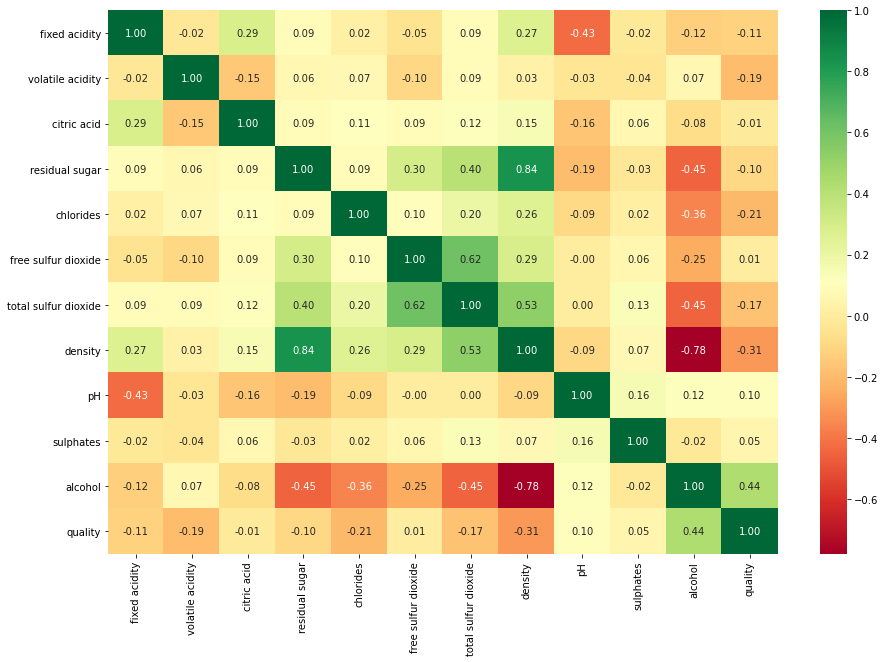

In [39]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(data_all[corr_cols_1].corr(), annot=True, fmt='.2f', cmap='RdYlGn')

<AxesSubplot:>

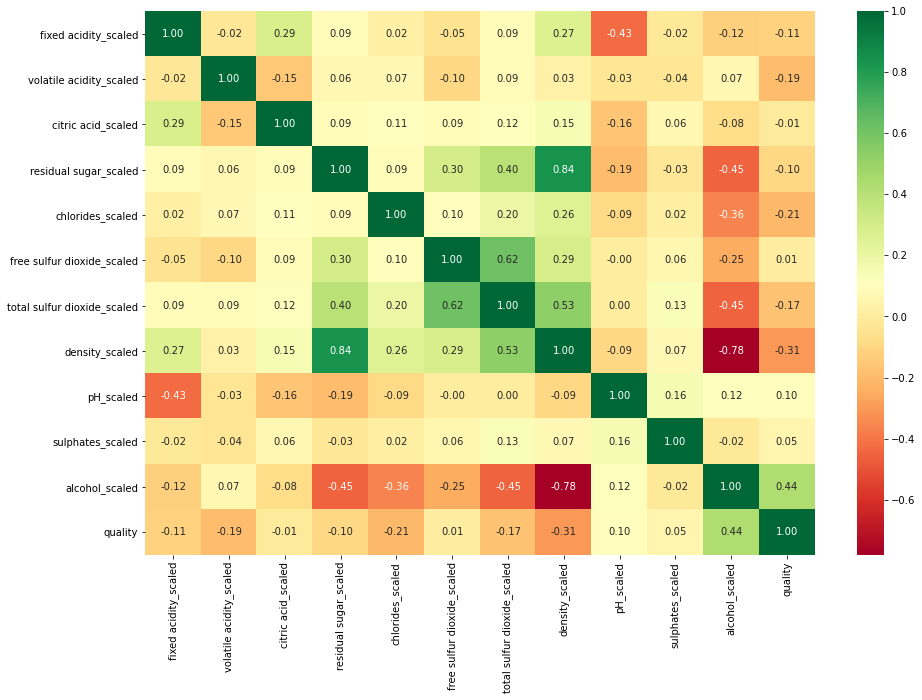

In [40]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(data_all[corr_cols_2].corr(), annot=True, fmt='.2f', cmap="RdYlGn")

Корреляционные матрицы для исходных и масштабированных данных полностью совпадают

## Выводы о коррелирующих признаках

1. Коэффициенты корреляции в данном наборе достаточно низкие. 
2. Все представленные входные параметры влияют на качество алкоголя, так как они определяют его химический состав. С этой точки зрения для построения моделей мы можем использовать все 11 признаков. Однако, для улучшения качества моделей исключим признаки, которые могут быть зависимы друг от друга.
3. 'alcohol' и 'density' лучше всего коррелируют с целевым признаком, однако они очень сильно коррелируют друг с другом (|0.78|), что может означать зависимость между ними и плохо влиять на построение моделей. 'alcohol' лучше коррелирует с целквым признаком, поэтому оставим его, а 'density' уберем.
4. 'free sulfur' и 'total sulfur'  неплохо коррелируют друг с другом (|0.62|), что логично, так как общий дикосид серы является сумма связной и свободной серы. У них прослеживается явная заивисмость. Уберем 'free sulfur' из признаков для построения модели. 


### Бинаризация данных
Так как наш целевой признак 'quality' включает в себя 7 значений, бинарная классификация невозможна. 

Чтобы бинаризировать 7 различных значений целевого признака, мы вместо одного целевого столбца 'quality' создаем 7 столбцов (каждый столбец соответствует определенному значению выходного параметра 'quality').

Каждый из семи столбцов является бинарным, то есть принимает значение "1", когда вино имеет оценку качества, соответствующую столбцу, и "0" — во всех остальных случаях. 

Все семь столбцов мы создали для наглядности и удобства. Как уже было скзаано выше, для задачи классификации мы будем использовать только оценку "6" и "7".

In [41]:
qual = pd.concat([train['quality'], test['quality']])

In [42]:
def code_myohe(data, column):
    for i in data[column].unique():
        data[column + '=' + str(i)] = (data[column] == i).astype(int)

In [43]:
code_myohe(data_all, 'quality')
data_all.head()

,dataset,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,...,pH_scaled,sulphates_scaled,alcohol_scaled,quality=6,quality=5,quality=7,quality=8,quality=4,quality=3,quality=9
0,TRAIN,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,...,0.254545,0.267442,0.129032,1,0,0,0,0,0,0
1,TRAIN,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,...,0.527273,0.313953,0.241935,1,0,0,0,0,0,0
2,TRAIN,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,...,0.490909,0.255814,0.338710,1,0,0,0,0,0,0
3,TRAIN,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,...,0.427273,0.209302,0.306452,1,0,0,0,0,0,0
4,TRAIN,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,...,0.427273,0.209302,0.306452,1,0,0,0,0,0,0


In [44]:
data_all['quality'] = qual

## 4) Выбор метрик для последующей оценки качества моделей.

**В качестве метрик для решения задачи классификации  будем использовать:**
- Метрика precision: $precision = \frac{TP}{TP+FP}$
- Метрика recall (полнота): $recall = \frac{TP}{TP+FN}$
- Метрика $F_1$-мера: $F_\beta = (1+\beta^2) \cdot \frac{precision \cdot recall}{precision + recall}$, где $\beta$ определяет вес точности в метрике.
- Метрика ROC AUC: $TPR = \frac{TP}{TP+FN}$ - True Positive Rate, откладывается по оси ординат. Совпадает с recall. $FPR = \frac{FP}{FP+TN}$ - False Positive Rate, откладывается по оси абсцисс. Показывает какую долю из объектов отрицательного класса алгоритм предсказал неверно.

### Введем класс, который позволит сохранять метрики качества построенных моделей и реализует визуализацию метрик качества

In [45]:
class MetricLogger:
    
    def __init__(self):
        self.df = pd.DataFrame(
            {'metric': pd.Series([], dtype='str'),
            'alg': pd.Series([], dtype='str'),
            'value': pd.Series([], dtype='float')})

    def add(self, metric, alg, value):
        """
        Добавление значения
        """
        # Удаление значения если оно уже было ранее добавлено
        self.df.drop(self.df[(self.df['metric']==metric)&(self.df['alg']==alg)].index, inplace = True)
        # Добавление нового значения
        temp = [{'metric':metric, 'alg':alg, 'value':value}]
        self.df = self.df.append(temp, ignore_index=True)

    def get_data_for_metric(self, metric, ascending=True):
        """
        Формирование данных с фильтром по метрике
        """
        temp_data = self.df[self.df['metric']==metric]
        temp_data_2 = temp_data.sort_values(by='value', ascending=ascending)
        return temp_data_2['alg'].values, temp_data_2['value'].values
    
    def plot(self, str_header, metric, ascending=True, figsize=(5, 5)):
        """
        Вывод графика
        """
        array_labels, array_metric = self.get_data_for_metric(metric, ascending)
        fig, ax1 = plt.subplots(figsize=figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos, array_metric,
                         align='center',
                         height=0.5, 
                         tick_label=array_labels)
        ax1.set_title(str_header)
        for a,b in zip(pos, array_metric):
            plt.text(0.5, a-0.05, str(round(b,3)), color='white')
        plt.show()

## Формирование обучающей и тестовой выборок на основе исходного набора данных.
### Выделим обучающую и тестовую выборки на основе масштабированных данных с помощью фильтра

In [46]:
train_data_all = data_all[data_all['dataset']=='TRAIN']
test_data_all = data_all[data_all['dataset']=='TEST']
train_data_all.shape, test_data_all.shape

((3500, 31), (1398, 31))

### Определим признаки для задачи классификации

In [47]:
# Признаки для задачи классификации
task_clas_cols = ['fixed acidity_scaled', 'volatile acidity_scaled', 'citric acid_scaled', 'residual sugar_scaled',
       'chlorides_scaled', 'total sulfur dioxide_scaled',
       'pH_scaled', 'sulphates_scaled', 'alcohol_scaled']

### Определим выборки для задачи классификации

In [48]:
# Выборки для задачи классификации
clas_X_train = train_data_all[task_clas_cols]
clas_X_test = test_data_all[task_clas_cols]

clas_Y6_train = train_data_all['quality=6']
clas_Y6_test = test_data_all['quality=6']

clas_Y7_train = train_data_all['quality=7']
clas_Y7_test = test_data_all['quality=7']

clas_X_train.shape, clas_X_test.shape, clas_Y6_train.shape, clas_Y6_test.shape

((3500, 9), (1398, 9), (3500,), (1398,))

### Построение базового решения 


### Определим модель

In [49]:
clas_models = {'LogR': LogisticRegression(),
               'SVC':SVC(),
               'Tree':DecisionTreeClassifier()}

### Сохранение метрик

In [50]:
clasMetricLogger = MetricLogger()

In [51]:
def clas_train_model7(model_name, model, clasMetricLogger):
    model.fit(clas_X_train, clas_Y7_train)
    Y_pred = model.predict(clas_X_test)
    precision = precision_score(clas_Y7_test.values, Y_pred)
    recall = recall_score(clas_Y7_test.values, Y_pred)
    f1 = f1_score(clas_Y7_test.values, Y_pred)
    roc_auc = roc_auc_score(clas_Y7_test.values, Y_pred)
    
    clasMetricLogger.add('precision', model_name, precision)
    clasMetricLogger.add('recall', model_name, recall)
    clasMetricLogger.add('f1', model_name, f1)
    clasMetricLogger.add('roc_auc', model_name, roc_auc)

    print('*****************************************************')
    print(model)
    print('*****************************************************')
    draw_roc_curve(clas_Y7_test.values, Y_pred)
    
    plot_confusion_matrix(model, clas_X_test, clas_Y7_test.values, 
                      display_labels=['0','1'], 
                      cmap=plt.cm.Blues, normalize='true')
    plt.show()

*****************************************************
LogisticRegression()
*****************************************************


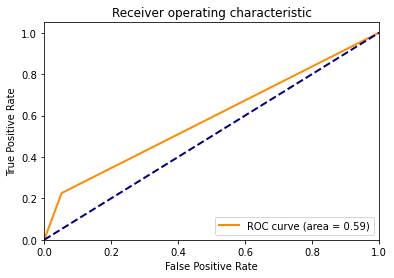

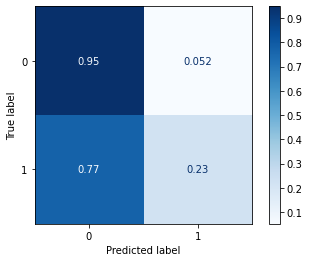

*****************************************************
SVC()
*****************************************************


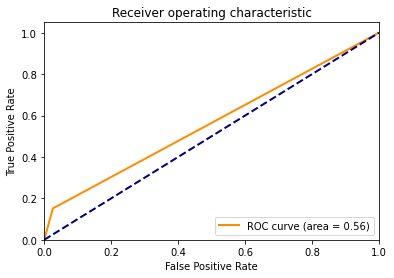

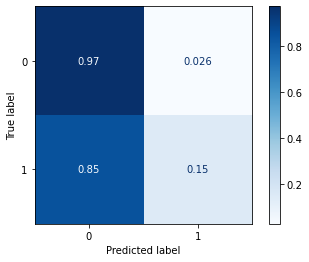

*****************************************************
DecisionTreeClassifier()
*****************************************************


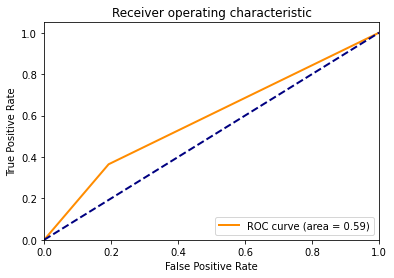

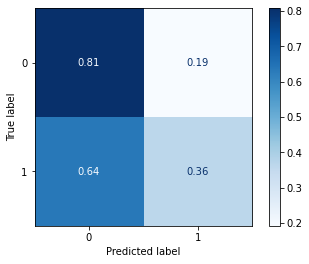

In [52]:
for model_name, model in clas_models.items():
    clas_train_model7(model_name, model, clasMetricLogger)

### 7) Подбор гиперпараметров 

In [53]:
clas_X_train.shape

(3500, 9)

In [54]:
tree_param = {'criterion':['gini','entropy'], 'splitter': ['best', 'random'], 'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150, 250, 500, 1000]}

clf_gs = GridSearchCV(DecisionTreeClassifier(), tree_param, cv=5)
clf_gs.fit(clas_X_train, clas_Y7_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30,
                                       40, 50, 70, 90, 120, 150, 250, 500,
                                       1000],
                         'splitter': ['best', 'random']})

### Лучшая модель

In [56]:
clf_gs.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=4, splitter='random')

### Лучшее значение параметров

In [57]:
clf_gs.best_params_

{'criterion': 'entropy', 'max_depth': 4, 'splitter': 'random'}

### 8) Сравнение качества полученных моделей с качеством baseline-моделей.


In [58]:
clas_models_grid = {'best_tree':clf_gs.best_estimator_}

*****************************************************
DecisionTreeClassifier(criterion='entropy', max_depth=4, splitter='random')
*****************************************************


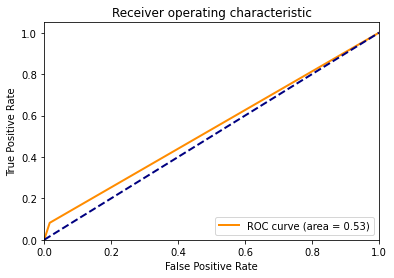

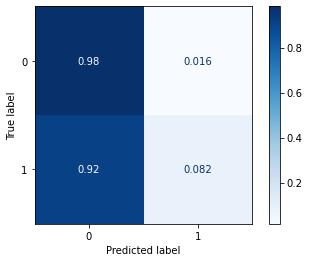

In [60]:
for model_name, model in clas_models_grid.items():
    clas_train_model7(model_name, model, clasMetricLogger)

### 9) Формирование выводов о качестве построенных моделей на основе выбранных метрик


### Метрики качества модели

In [61]:
clas_metrics = clasMetricLogger.df['metric'].unique()
clas_metrics

array(['precision', 'recall', 'f1', 'roc_auc'], dtype=object)

### Графики метрик качества модели

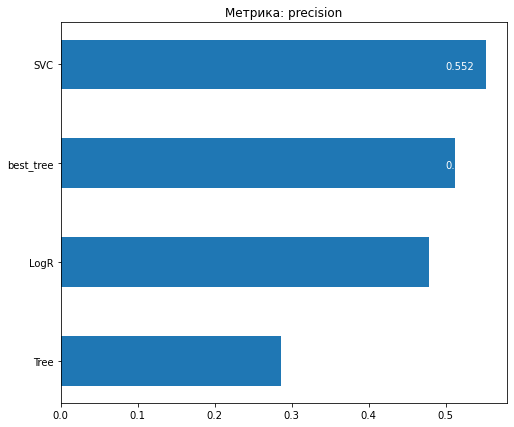

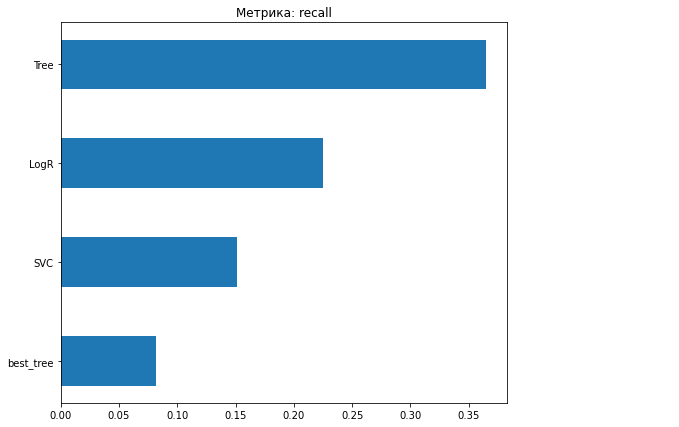

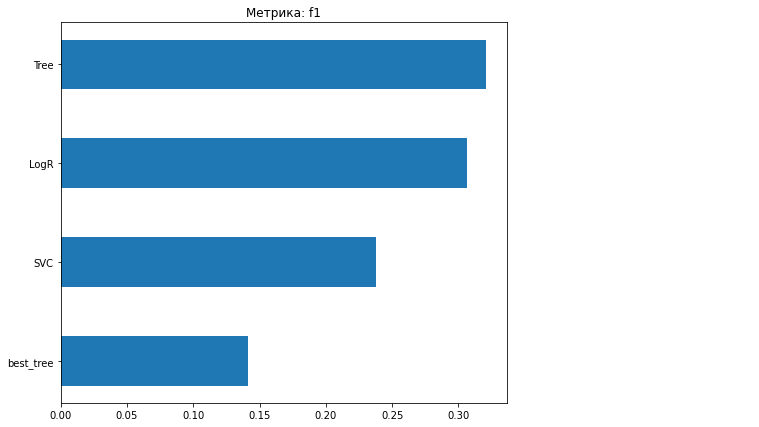

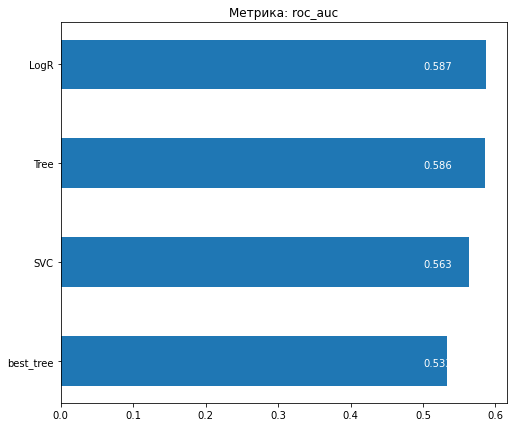

In [62]:
for metric in clas_metrics:
    clasMetricLogger.plot('Метрика: ' + metric, metric, figsize=(8, 7))

### Вывод
Без гиперпараметров точность расчетов моделей оказалась точнее. 